## Ames Housing Data: Price Prediction With Ensemble Methods

![House for sale](house.jpg)

The goal of this project is to build a model on the Ames Housing dataset with Linear Models and Ensemble Methods,
and to demonstrate skills in pandas, scipy, numpy, scikit-learn and data visualization libraries. After investigating,
cleaning, and engineering the data, an ensemble model is built and tuned using hyperparameter search. A cross-validated
performance of ~.107 root mean square error is achieved, which is commensurate with the top ~5 percent of entries for
this data set on Kaggle. 

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import cross_val_score, train_test_split, ParameterGrid, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, BayesianRidge, ElasticNet, Lasso
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor
from sklearn import svm
from scipy import stats
from mlxtend.regressor import StackingRegressor
import xgboost as xb
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

First we will examine our data to get an idea of what we are working with

In [5]:
ames_train = pd.read_csv('train.csv')
ames_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [6]:
ames_train.describe()

Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726   
std       1.112799    30.202904     20.645407   181.066207   456.098091   
min       1.000000  1872.000000   1950.000000     0.000000     0.000000   
25%       5.000000  1954.000000   1967.000000     0.000000     0.000000   
50%       5.000000  1973.000000   1994.000000     0.000000   383.500000   
75%       6.000000  2000.000000   2004.000000   166.000000   712.250000   
max       9.000000  2010.000000   2010.000000  1600.000000  5644.000000   

           ...         WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  \
count      ...        1460.000000  1460.000000    1460.000000  1460.000000   
mean       ...          94.244521    46.660274      21.954110     3.409589   
std        ...         125.338794    66.256028      61.119149    29.317331   
min        ...           0.000000     0.000000       0.000000     0.000000   
25%        ...           0.000000     0.000000       0.000000     0.000000   
50%        ...           0.000000    25.000000       0.000000     0.000000   
75%        ...         168.000000    68.000000       0.000000     0.000000   
max        ...         857.000000   547.000000     552.000000   508.000000   

       ScreenPorch     PoolArea       MiscVal       MoSold       YrSold  \
count  1460.000000  1460.000000   1460.000000  1460.000000  1460.000000   
mean     15.060959     2.758904     43.489041     6.321918  2007.815753   
std      55.757415    40.177307    496.123024     2.703626     1.328095   
min       0.000000     0.000000      0.000000     1.000000  2006.000000   
25%       0.000000     0.000000      0.000000     5.000000  2007.000000   
50%       0.000000     0.000000      0.000000     6.000000  2008.000000   
75%       0.000000     0.000000      0.000000     8.000000  2009.000000   
max     480.000000   738.000000  15500.000000    12.000000  2010.000000   

           SalePrice  
count    1460.000000  
mean   180921.195890  
std     79442.502883  
min     34900.000000  
25%    129975.000000  
50%    163000.000000  
75%    214000.000000  
max    755000.000000  

[8 rows x 38 columns]

We have a numeric response, so we'll use a histogram and a rug plot to see what the data looks like. 

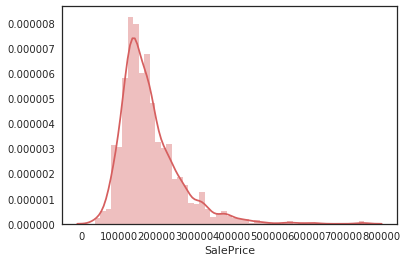

In [7]:
#histogram plot for our response variable
sns.set(style="white", palette="muted", color_codes=True)
sns.distplot(ames_train['SalePrice'], color='r')

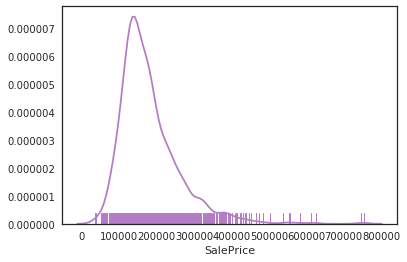

In [8]:
##rug plot for our response variable 
sns.distplot(ames_train['SalePrice'], hist=False, rug=True, color='m');

In [9]:
##print out some basic statistics about our response's distribution
print("Std: %f" % ames_train['SalePrice'].std())
print("Skewness: %f" % ames_train['SalePrice'].skew() )
print( "Kurtosis: %f" % ames_train['SalePrice'].kurt() )

Std: 79442.502883
Skewness: 1.882876
Kurtosis: 6.536282


Build a correlation heatmap using the ~10 highest correlated predictors. This gives a rough idea of how useful 
these predictors might be. 

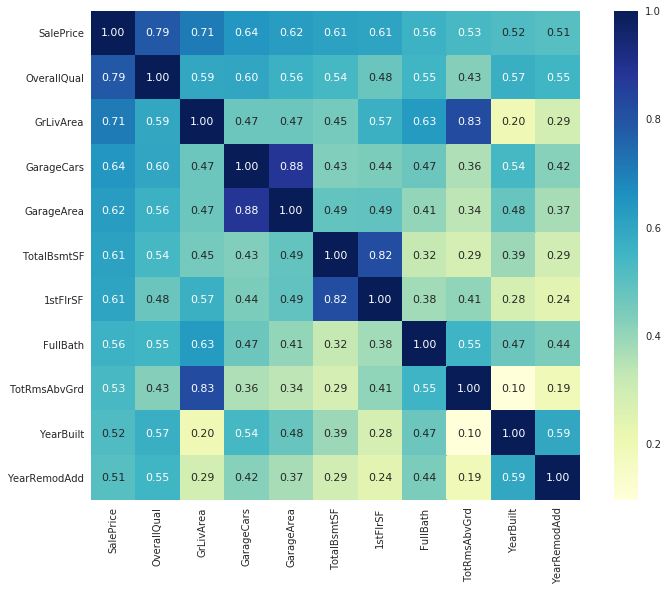

In [10]:
f, ax = plt.subplots(figsize=(12, 9))
correlation_matrix = ames_train.corr()
cols = correlation_matrix.nlargest(11, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(ames_train[cols].values.T)
sns.set(font_scale=1.0)
hm = sns.heatmap(cm, cbar=True, cmap="YlGnBu", annot=True, square=True, fmt='.2f', annot_kws={'size': 11}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Seaborn has some very nice plotting capabilites, including the ability to do pair-plotting with histograms,
scatter-plots, and kernel density estimation plots. This is a good way to get a feel for our response and important
predictors

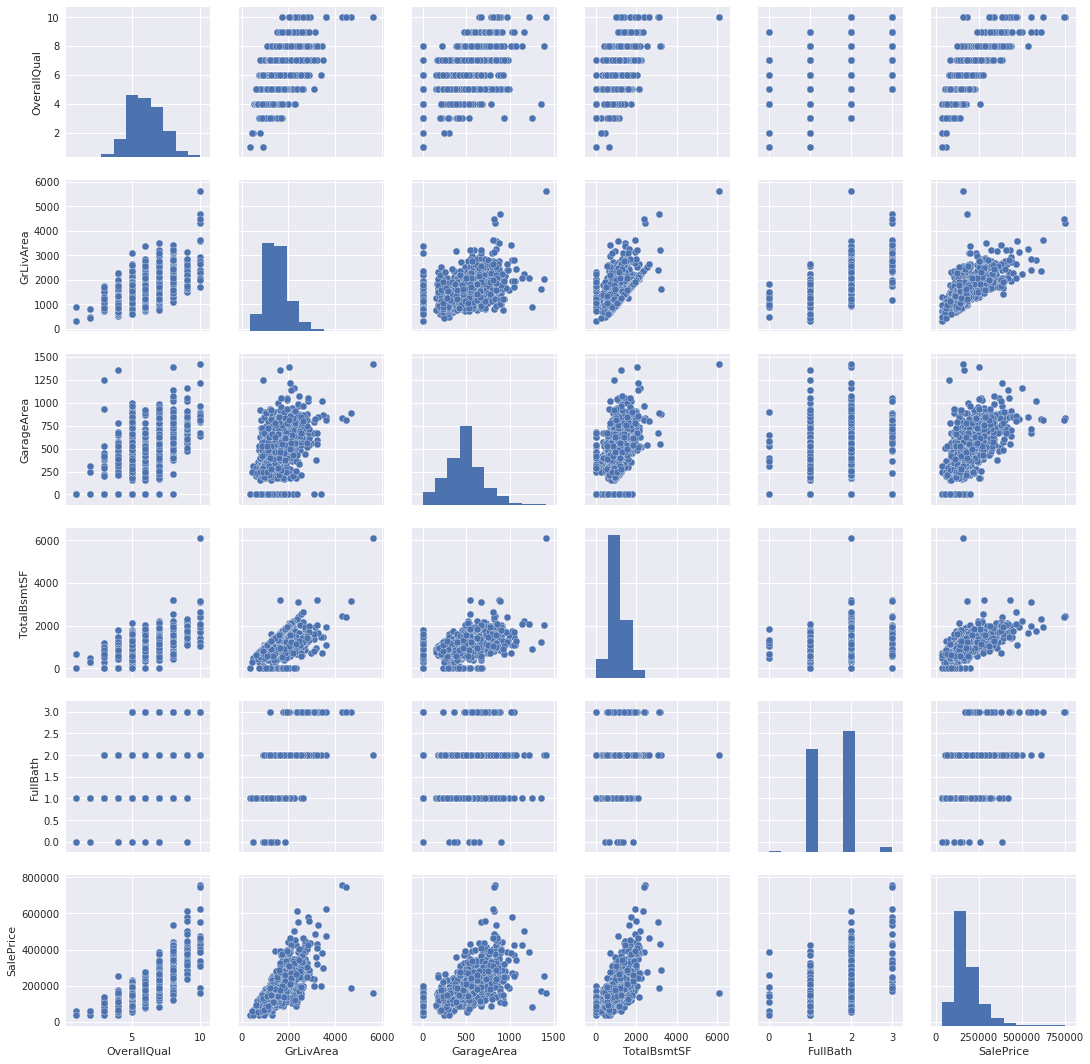

In [11]:
#scatterplot and histogram pair plot
#notice the outliers in the scatter plots
cols=['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', 'FullBath', 'SalePrice']
sns.set()
sns.pairplot(ames_train[cols], size = 2.5)
plt.show()

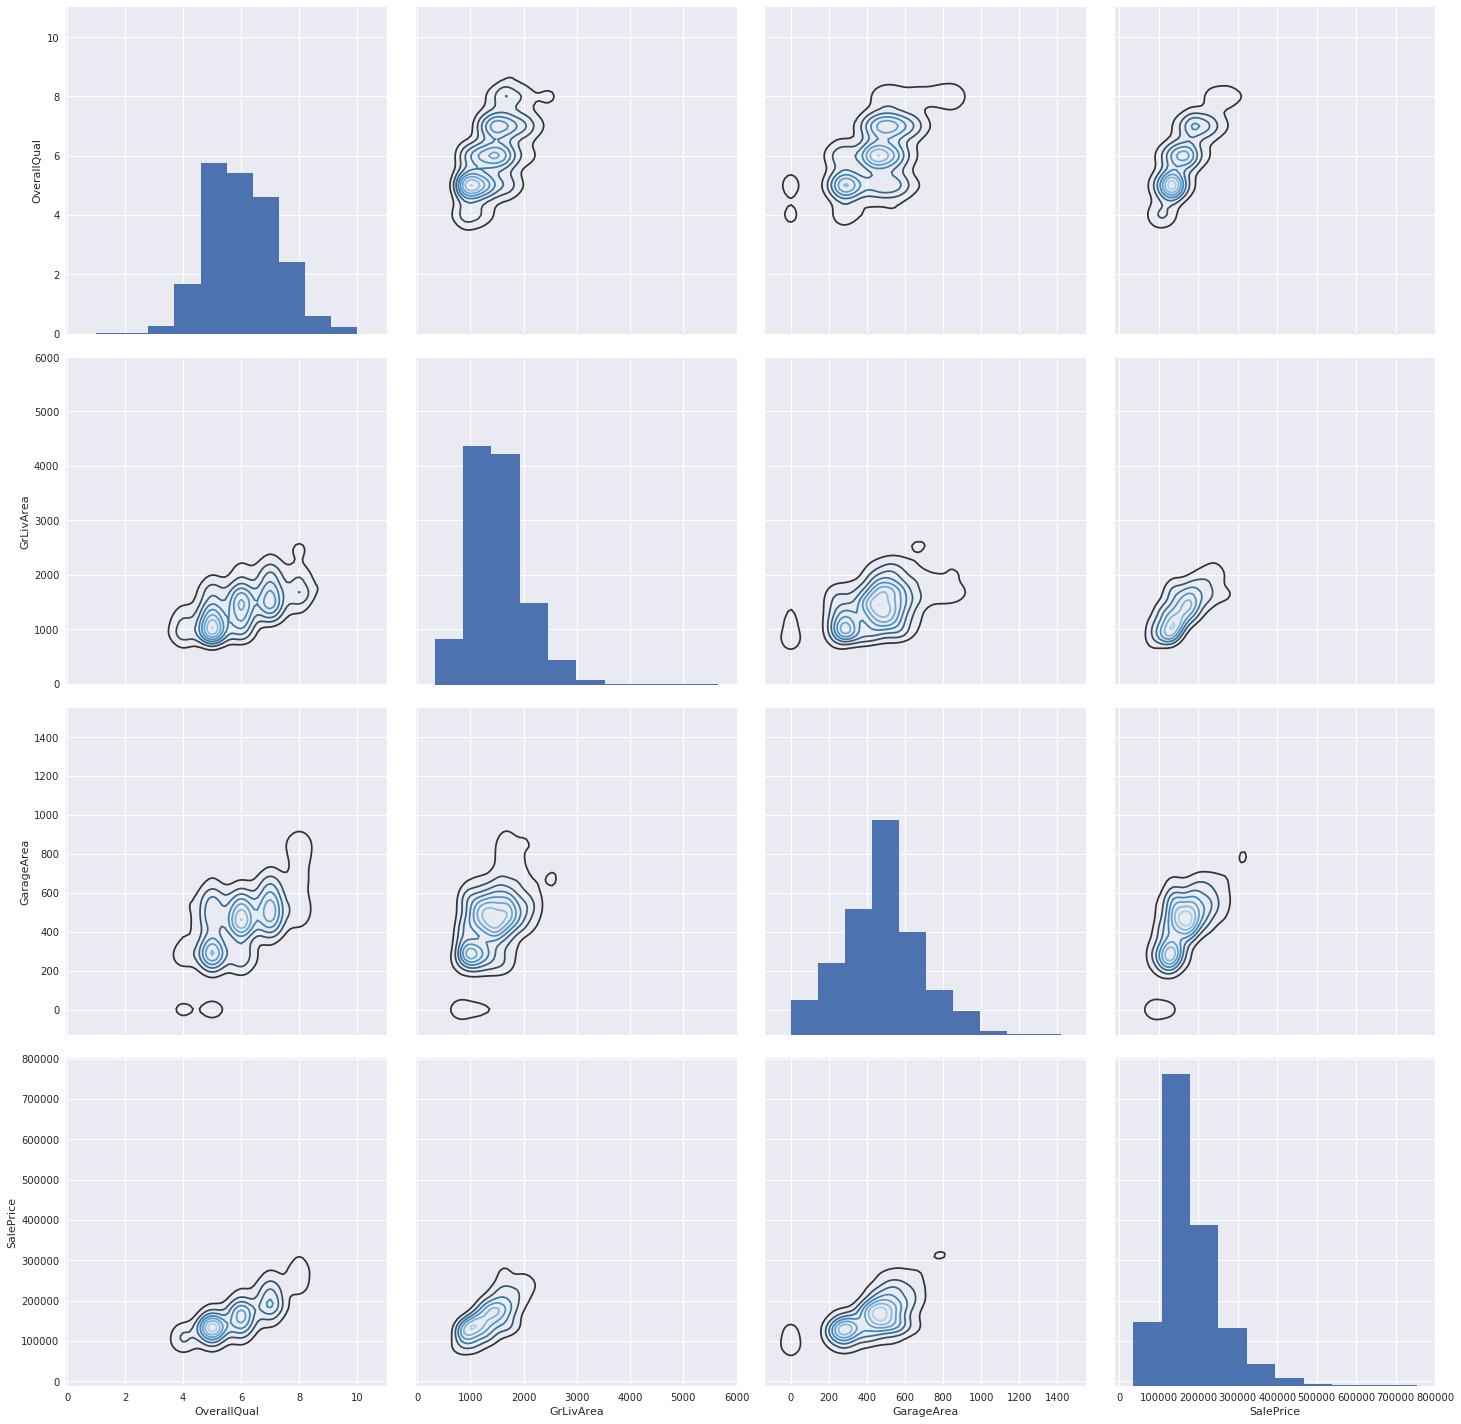

In [12]:
###kernel density plots for the higher correlation variables
##we can see some outliers here as well, along with instances where there are clusters of values around 0
cols=['OverallQual', 'GrLivArea', 'GarageArea','SalePrice']
g = sns.PairGrid( ames_train[cols], size=5 )
g.map_diag(plt.hist)
g.map_offdiag(sns.kdeplot, cmap="Blues_d", n_levels=8 )
plt.show()

### Data Cleaning

As always, the first order of business is to check for missing values in our data.

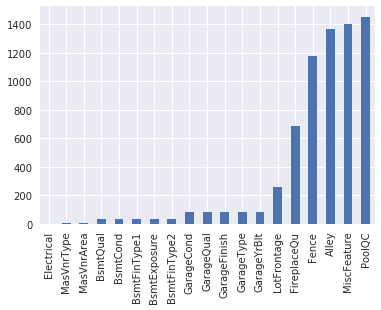

In [13]:
#Now we can begin cleaning and preprocessing the data
#First, find and deal with missing data
missing = ames_train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

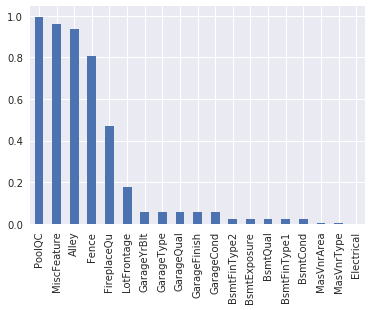

In [14]:
#plot missing values as a percentage
percent = (missing/ames_train.isnull().count()).sort_values(ascending=False)
percent = percent[ percent > 0]
percent.plot.bar()

In [15]:
#I will drop anything with over 10% missing data, none of these variables seem very important anyway
ames_train = ames_train.drop( percent[ percent > 0.10 ].index, axis=1 )

In [16]:
##check data
ames_train.head(5)

Id  MSSubClass MSZoning  LotArea Street LotShape LandContour Utilities  \
0   1          60       RL     8450   Pave      Reg         Lvl    AllPub   
1   2          20       RL     9600   Pave      Reg         Lvl    AllPub   
2   3          60       RL    11250   Pave      IR1         Lvl    AllPub   
3   4          70       RL     9550   Pave      IR1         Lvl    AllPub   
4   5          60       RL    14260   Pave      IR1         Lvl    AllPub   

  LotConfig LandSlope    ...    EnclosedPorch 3SsnPorch ScreenPorch PoolArea  \
0    Inside       Gtl    ...                0         0           0        0   
1       FR2       Gtl    ...                0         0           0        0   
2    Inside       Gtl    ...                0         0           0        0   
3    Corner       Gtl    ...              272         0           0        0   
4       FR2       Gtl    ...                0         0           0        0   

  MiscVal  MoSold  YrSold  SaleType  SaleCondition SalePrice  
0       0       2    2008        WD         Normal    208500  
1       0       5    2007        WD         Normal    181500  
2       0       9    2008        WD         Normal    223500  
3       0       2    2006        WD        Abnorml    140000  
4       0      12    2008        WD         Normal    250000  

[5 rows x 75 columns]

In [17]:
##Eliminate 1 missing data member from electrical 
ames_train = ames_train.drop( ames_train.loc[ames_train['Electrical'].isnull()].index )

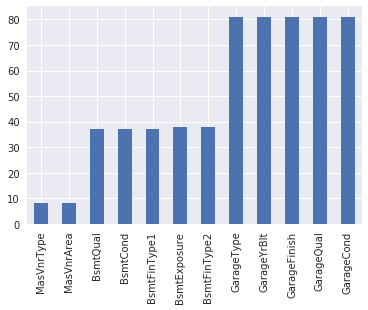

In [18]:
##Now check for missing data 
missing = ames_train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

In [19]:
#Note: Testing showed that this decreased performance
#Fill N/As that are most likely None or some other value
#ames_train['Functional'] = ames_train['Functional'].fillna("Typ")
#for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MSSubClass', 'MasVnrType',
#           'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
#    ames_train[col] = ames_train[col].fillna("None")
#for col in ('MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',
#           'GarageYrBlt', 'GarageArea', 'GarageCars'):
#    ames_train[col] = ames_train[col].fillna(0)

I suspect many of the remaining missing values for many of these variables are the same observations
Printing out missing value locations confirms this

In [21]:
print( ames_train.loc[ames_train['MasVnrType'].isnull()].index )
print( ames_train.loc[ames_train['MasVnrArea'].isnull()].index )
print( ames_train.loc[ames_train['BsmtQual'].isnull()].index )
print( ames_train.loc[ames_train['BsmtCond'].isnull()].index )
print( ames_train.loc[ames_train['BsmtExposure'].isnull()].index )
print( ames_train.loc[ames_train['BsmtFinType2'].isnull()].index )
print( ames_train.loc[ames_train['BsmtFinType1'].isnull()].index )
print( ames_train.loc[ames_train['GarageType'].isnull()].index )
print( ames_train.loc[ames_train['GarageQual'].isnull()].index )

Int64Index([234, 529, 650, 936, 973, 977, 1243, 1278], dtype='int64')
Int64Index([234, 529, 650, 936, 973, 977, 1243, 1278], dtype='int64')
Int64Index([  17,   39,   90,  102,  156,  182,  259,  342,  362,  371,  392,
             520,  532,  533,  553,  646,  705,  736,  749,  778,  868,  894,
             897,  984, 1000, 1011, 1035, 1045, 1048, 1049, 1090, 1179, 1216,
            1218, 1232, 1321, 1412],
           dtype='int64')
Int64Index([  17,   39,   90,  102,  156,  182,  259,  342,  362,  371,  392,
             520,  532,  533,  553,  646,  705,  736,  749,  778,  868,  894,
             897,  984, 1000, 1011, 1035, 1045, 1048, 1049, 1090, 1179, 1216,
            1218, 1232, 1321, 1412],
           dtype='int64')
Int64Index([  17,   39,   90,  102,  156,  182,  259,  342,  362,  371,  392,
             520,  532,  533,  553,  646,  705,  736,  749,  778,  868,  894,
             897,  948,  984, 1000, 1011, 1035, 1045, 1048, 1049, 1090, 1179,
            1216, 1218, 1232, 13

There aren't that many missing values compared to the size of our dataset, and testing has shown that substituting
likely values does not improve performance, so I will simply drop these rows from our dataset. 

In [22]:
ames_train = ames_train.drop( ames_train.loc[ames_train['MasVnrType'].isnull()].index )
ames_train = ames_train.drop( ames_train.loc[ames_train['BsmtQual'].isnull()].index )
ames_train = ames_train.drop( ames_train.loc[ames_train['BsmtExposure'].isnull()].index )
ames_train = ames_train.drop( ames_train.loc[ames_train['GarageType'].isnull()].index )
ames_train = ames_train.drop( ames_train.loc[ames_train['BsmtFinType2'].isnull()].index ) ##there is one more here

In [25]:
#Check to make sure we got all of the missing data
ames_train.isnull().sum().sum()

0

### Outliers

Missing data has been taken care of. Now we can deal with outliers. As we saw on the scatter plots earlier, there
are several outliers in our important predictors that are rather extreme. Given the size of the dataset, it is
probably safe to delete these cases. They likely represent aberrations that do not need to be taken into account to build a good model. This course of action is recommended by the dataset's authors, as well. 

In [26]:
ames_train = ames_train[ ames_train['GrLivArea'] < 4000 ]
ames_train = ames_train[ ames_train['TotalBsmtSF'] < 4000 ]
ames_train = ames_train[ ames_train['GarageArea'] < 1250 ]
# There may be outliers in many of the other variables, but they are likely not so important
# Right now it is best to only be concerned with the most appealing predictors

### Feature Engineering

Features will be split into numerical and categorical subsets, then engineered. New features will be added,
and existing features will be scaled and transformed for use in machine learning algorithms. 

In [27]:
##It's now time to split our data into numerical and categorical predictors
categorical_features = ames_train.select_dtypes(include = ["object"]).columns
numerical_features = ames_train.select_dtypes(exclude = ["object"]).columns
numerical_features = numerical_features.drop("SalePrice")

ames_num = ames_train[numerical_features]
ames_cat = ames_train[categorical_features]

In [28]:
#Check the normality of some of our important predictors
for pred in ['GrLivArea', 'TotalBsmtSF', 'GarageArea', 'FullBath', 'OverallQual', '1stFlrSF', 'GarageCars']:
    print( "Results for " + pred + ":" )
    print(stats.normaltest( ames_train[pred]))
# The p-values reported here are for the null hypothesis that the variable is from a normal distribution
# As we can see, the majority of these variables are likely not from such a distribution
# The 'statistic' value is skewness squared plus kurtosis squared. Many of the non-normal variables have high 
# skewness, kurtosis or both

Results for GrLivArea:
NormaltestResult(statistic=150.66423147598857, pvalue=1.9216656400286613e-33)
Results for TotalBsmtSF:
NormaltestResult(statistic=176.84137528111808, pvalue=3.9754223188900107e-39)
Results for GarageArea:
NormaltestResult(statistic=86.170431100092657, pvalue=1.9423551212839049e-19)
Results for FullBath:
NormaltestResult(statistic=188.73672580982893, pvalue=1.0383427243429248e-41)
Results for OverallQual:
NormaltestResult(statistic=17.98807151950496, pvalue=0.00012414804915421095)
Results for 1stFlrSF:
NormaltestResult(statistic=153.48698389261335, pvalue=4.6851653824842886e-34)
Results for GarageCars:
NormaltestResult(statistic=11.695436294966658, pvalue=0.0028864781665387182)


In [29]:
#I will apply log-transform to all features where we reject null hypothesis, alpha = 0.01
def get_p( x ):
    s, p = stats.normaltest(x)
    return p
alpha = 0.01
norm_p = ames_num.apply(lambda x : get_p(x))
norm_p = norm_p[norm_p < alpha]
print(str(norm_p.shape[0]) + " numerical features to log transform")
logt_features = norm_p.index
ames_num[logt_features] = np.log1p(ames_num[logt_features])

36 numerical features to log transform


In [30]:
#also we will log-transform the response variable
ames_train['SalePrice'] = np.log( ames_train['SalePrice'])

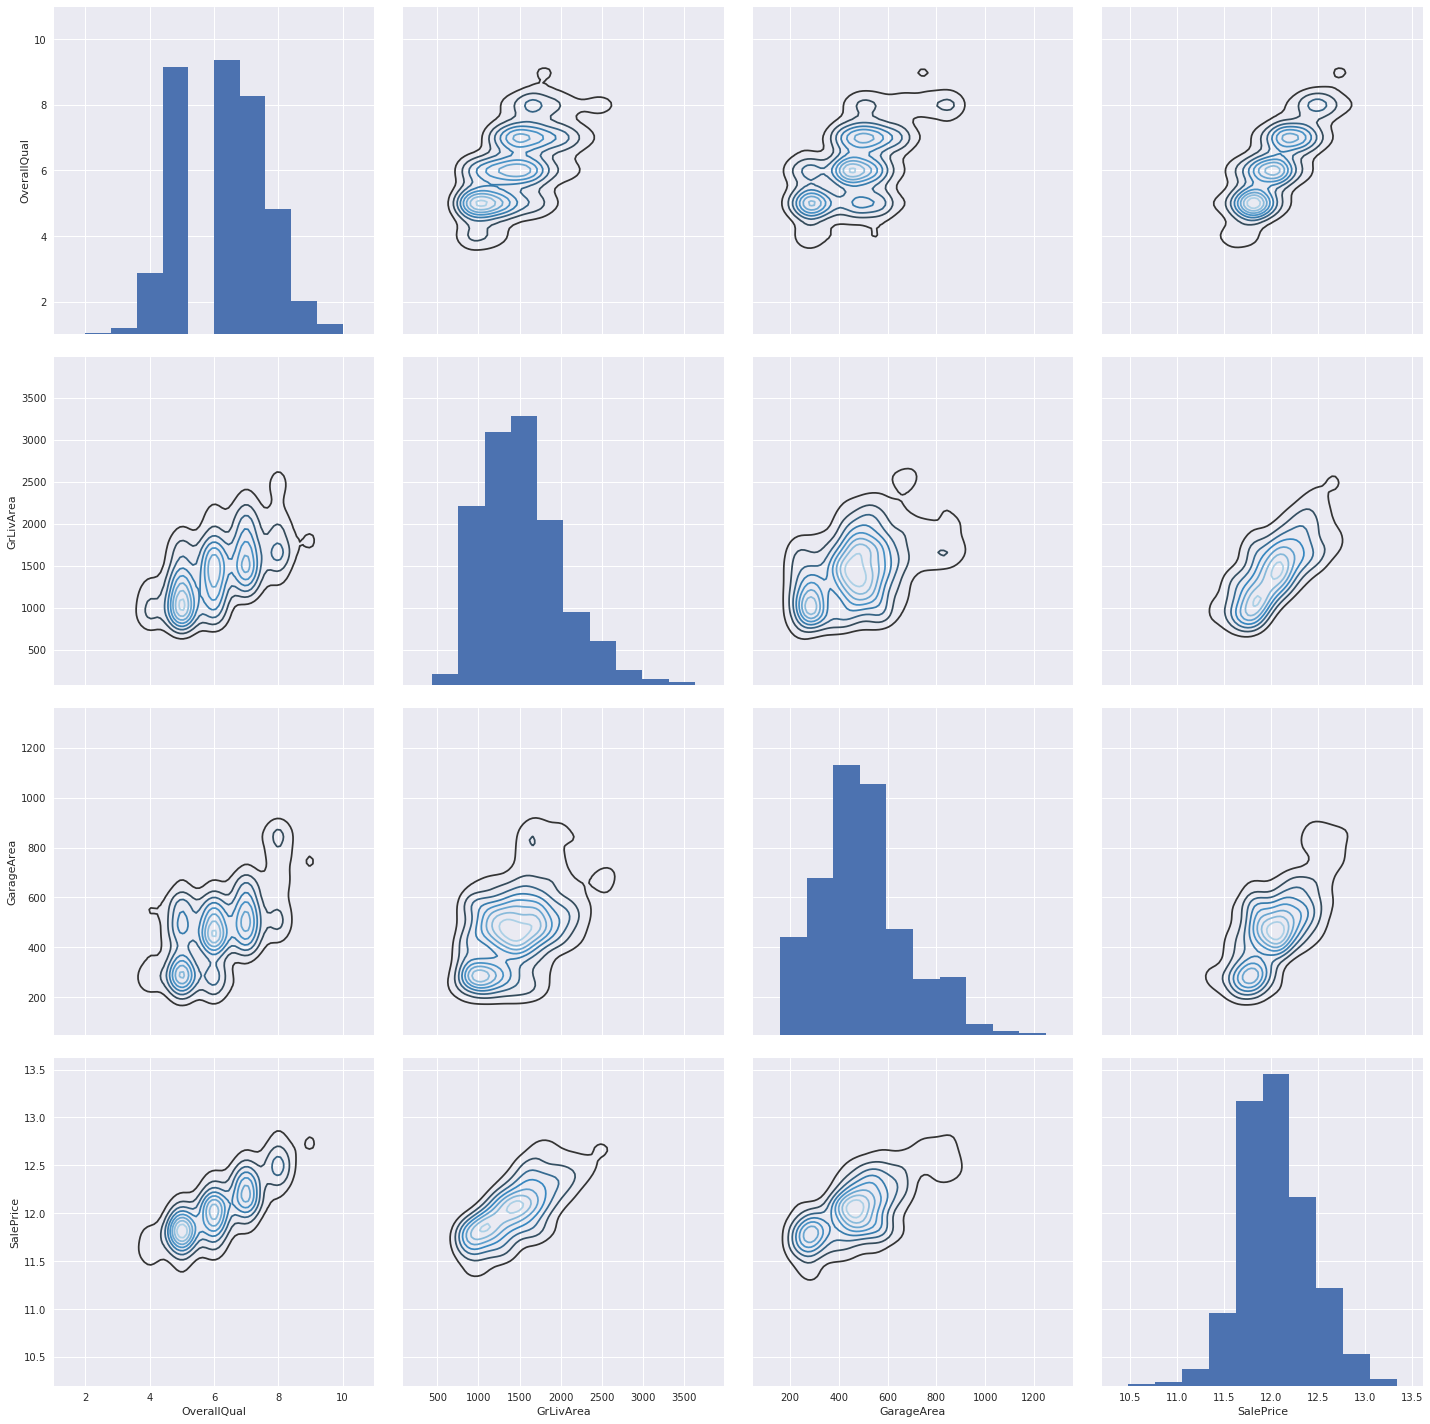

In [31]:
# Look at some kernel denisty plots again
# The histograms and KDE plots look better
# Kernel density plots for the higher correlation variables
# We can see some outliers here as well, along with instances where there are clusters of values around 0
cols=['OverallQual', 'GrLivArea', 'GarageArea','SalePrice']
g = sns.PairGrid( ames_train[cols], size=5 )
g.map_diag(plt.hist)
g.map_offdiag(sns.kdeplot, cmap="Blues_d", n_levels=8 )
plt.show()

In [32]:
# Add dummy variables for categorical variables
ames_cat = pd.get_dummies(ames_cat)
# Check to make sure there are no missing vals ( again )
print("NAs for categorical features in train : " + str(ames_cat.isnull().values.sum()))

NAs for categorical features in train : 0


A couple of numerical features will be added at this point. This dataset already has a lot of features, so we don't
want to add too many more without good reason, as this can create it's own problems due to the Curse of Dimensionality. 

So first, let's see if a good model can be built without throwing everything and the kitchen sink into an already 
large dataframe. 

In [33]:
##Add some features
#Account for feature combinations that might improve value for rental or subletting
ames_num['RentalVal'] = ames_num['FullBath'] * ames_num['KitchenAbvGr'] * ames_num['BedroomAbvGr']
ames_num['RentalValBsmt'] = (ames_num['BsmtFullBath'] + ames_num['BsmtHalfBath']) * ames_num['BsmtFinSF1']
ames_num['GrLivArea^2'] = ames_num['GrLivArea']**2
ames_num['GarageCars^2'] = ames_num['GarageCars']**2
ames_num['OverallQual^2'] = ames_num['OverallQual']**2
ames_num['OverallQual^3'] = ames_num['OverallQual']**3

In [34]:
# Join our numerical and categorical features back together

X = pd.concat( [ ames_num, ames_cat], axis= 1 )

#make y from original data
y = ames_train['SalePrice']

Originally, PCA was performed in order to reduce dimensionality of the data. This did not turn out to be justified, as it resulted in poorer performance across the board at later stages. 

In [35]:
# Perform PCA on our training data
"""
pca = PCA(50, whiten=True)
pca.fit(X)
print(pca.explained_variance_ratio_) 

X_pca = pca.fit_transform(X)
print( X_pca.shape )
"""

'\npca = PCA(50, whiten=True)\npca.fit(X)\nprint(pca.explained_variance_ratio_) \n\nX_pca = pca.fit_transform(X)\nprint( X_pca.shape )\n'

### Model Construction

We'll begin by investigating several different algorithms to see what sticks. There are certainly more systematic
ways to approach this task, but this dataset isn't large enough to make trying many different methods impractical. 

In [41]:
#Define cross validation scorer
scorer = make_scorer(mean_squared_error, greater_is_better = False)
#Reducer for scores
def avg(score_arr):
    total = 0.0
    count = 0.0
    for score in score_arr:
        total += score
        count += 1.0
    return total / count
def rmse_cv_pca(model):
    rmse= np.sqrt(-cross_val_score(model, X_pca, y, scoring = scorer, cv = 3))
    return(avg(rmse))

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X, y, scoring = scorer, cv = 3))
    return(avg(rmse))
#For use in non-CV testing
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [42]:
##build model and pipeline
RF_pipe = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=200))

In [38]:
##Cross validate
print( "Radom forest without PCA " + str( rmse_cv( RF_pipe )))
# PCA does not appear to help
#print( "Random forest with PCA " + str( rmse_cv_pca( RF_pipe)))
# Note: Random forest does not perform very well, but perhaps it will do better when used in ensemble with
# linear methods. The two techniques may be wrong in different places and be synergistic when averaged
# Most linear models seem to hit ~.115 - ~.117 by themselves

Radom forest without PCA0.137181297641


In [39]:
# Now try some linear models
##build pipes for linear models
R_pipe = make_pipeline( RobustScaler(), Ridge())
BR_pipe = make_pipeline( RobustScaler(), BayesianRidge(alpha_1=0.0005 ) )
Lasso_pipe = make_pipeline( RobustScaler(), Lasso(alpha=0.0005, random_state=1) )
Els_pipe = make_pipeline( RobustScaler(), ElasticNet(alpha=0.005, random_state=1) )

In [40]:
##Cross validate
print( "Ridge " + str( rmse_cv( R_pipe )))
print( "Bayesian Ridge " + str( rmse_cv( BR_pipe )))
print( "Lasso " + str( rmse_cv( Lasso_pipe )))
print( "ElasticNet " + str( rmse_cv( Els_pipe )))

Ridge 0.111502850645
Bayesian Ridge 0.108727228177
Lasso 0.106453436512
ElasticNet 0.113674552689


Bayesian ridge regression without PCA looks promising. An error < .11 would put us towards the tope of the charts
for this competition.

We will do hyperparameter search using GridSearchCv.

In [53]:
# 
#See output two cells below for best params

alpha_1s = np.array( [1e-16, 1e-14, 1e-12, 1e-10, 1e-8, 1e-6, 1e-4, 1e-2 ] )
alpha_2s = np.array( [1e-16, 1e-14, 1e-12, 1e-10, 1e-8, 1e-6, 1e-4, 1e-2 ] )
lambda_1s = np.array( [1e-16, 1e-14, 1e-12, 1e-10, 1e-8, 1e-6, 1e-4, 1e-2 ] )
lambda_2s = np.array( [1e-16, 1e-14, 1e-12, 1e-10, 1e-8, 1e-6, 1e-4, 1e-2 ] )
n_iters = np.array([300, 600, 900])
normalizes = np.array([True, False])
param_grid =  { 'alpha_1' : alpha_1s, 'alpha_2': alpha_2s, 'lambda_1': lambda_1s, 'lambda_2': lambda_2s
              , 'n_iter' : n_iters, 'normalize' : normalizes }
gs = GridSearchCV( BayesianRidge(), param_grid, scoring='neg_mean_squared_error' )
GS_pipe = make_pipeline( StandardScaler(), gs )
GS_pipe.fit(X, y)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gridsearchcv', GridSearchCV(cv=None, error_score='raise',
       estimator=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n...*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0))])

In [35]:
# sorted(gs.cv_results_.keys())

In [55]:
print( "Best score: %f " % gs.best_score_)
gs.best_params_
#Best params:

# {'alpha_1': 9.9999999999999998e-17,
# 'alpha_2': 0.01,
# 'lambda_1': 0.01,
# 'lambda_2': 9.9999999999999998e-17,
# 'n_iter': 300,
# 'normalize': False}

Best score: -0.012540 


{'alpha_1': 9.9999999999999998e-13,
 'alpha_2': 0.01,
 'lambda_1': 0.01,
 'lambda_2': 9.9999999999999998e-17,
 'n_iter': 300,
 'normalize': False}

In [60]:
BR_GS_pipe = make_pipeline( RobustScaler(), BayesianRidge(alpha_1=9.9999999999999998e-13, alpha_2=0.01, lambda_1=0.01, lambda_2=9.9999999999999998e-17 ) )

In [61]:
print( "BR without PCA " + str( rmse_cv( BR_GS_pipe )))
# PCA does not appear to help
print( "BR with PCA " + str( rmse_cv_pca( BR_GS_pipe)))

BR without PCA 0.108723506927
BR with PCA 0.132835069238


In [39]:
#We're going to stack, first try some more tree models

In [40]:
#Lets try an Adaboost regressor and a Bagging regressor using a Bayesian Regression estimator
Ada_regr = AdaBoostRegressor( n_estimators=10000, learning_rate=0.5)
Bagging_regr = BaggingRegressor( n_estimators=500 )
#Make Pipelines
Ada_pipe = make_pipeline( StandardScaler(), Ada_regr )
Bag_pipe = make_pipeline( StandardScaler(), Bagging_regr )

In [41]:
#AdaBoost and Bagging
#Don't work very well
#print( "AdaBoost " + str( rmse_cv( Ada_pipe )))
#print( "Bagging" + str( rmse_cv( Bag_pipe)))

In [49]:
#XGBoost
xgb_regr = xb.XGBRegressor()
xgb_pipe = make_pipeline( RobustScaler(), xgb_regr )
print("XGB performance CV " + str(rmse_cv(xgb_pipe)))
#Support Vector Machine Regressor
svm_regr = svm.SVR()
svm_pipe = make_pipeline( RobustScaler(), svm_regr)
print("SVM performance CV " + str(rmse_cv(svm_pipe)))

XGB performance CV 0.119574706904
SVM performance CV 0.116753283193


### Build Ensemble Regressor

Using several of our well-performing algorithms from above, we will build a Stacked Regressor and do hyperparameter
search on it.

The rest of this notebook is a series of iterative refinements and hyperparameter searches to our ensemble model,
concluding with a remark about final performance. 

In [86]:
bayesian_ridge = BayesianRidge(alpha_1=9.9999999999999998e-13, alpha_2=0.01, lambda_1=0.01, lambda_2=9.9999999999999998e-17)
lasso = Lasso( random_state=1)
elastic = ElasticNet( random_state=1)
ridge = Ridge()
svr = svm.SVR()
meta_lasso = Lasso( random_state=1) #meta
stacked_regr = StackingRegressor( regressors=[bayesian_ridge, lasso, elastic, svm_regr], meta_regressor=meta_lasso)
#print( stacked_regr.get_params().keys() )
params = {'lasso__alpha': [ 1e-7, 5e-7, 1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 5e-4, 0.05, 0.1 ],
          'elasticnet__alpha': [1e-7, 5e-7, 1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 5e-4, 0.05, 0.1],
          'svr__C': [1, 10, 100, 500,1000],
          'svr__gamma': [1e-7, 5e-7, 1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 5e-4, 0.05, 0.1],
         'meta-lasso__alpha': [1e-7, 5e-7, 1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 5e-4, 0.05, 0.1, 0.5, 1.0] }

grid = GridSearchCV(estimator=stacked_regr, 
                    param_grid=params, 
                    refit=True,
                   scoring='neg_mean_squared_error')

grid_pipe = make_pipeline( RobustScaler(), grid )
grid_pipe.fit(X, y)

for params, mean_score, scores in grid.grid_scores_:
        print("%0.3f +/- %0.2f %r"
              % (mean_score, scores.std() / 2.0, params))

-0.014 +/- 0.00 {'elasticnet__alpha': 1e-07, 'lasso__alpha': 1e-07, 'meta-lasso__alpha': 1e-07, 'svr__C': 1, 'svr__gamma': 1e-07}
-0.014 +/- 0.00 {'elasticnet__alpha': 1e-07, 'lasso__alpha': 1e-07, 'meta-lasso__alpha': 1e-07, 'svr__C': 1, 'svr__gamma': 5e-07}
-0.014 +/- 0.00 {'elasticnet__alpha': 1e-07, 'lasso__alpha': 1e-07, 'meta-lasso__alpha': 1e-07, 'svr__C': 1, 'svr__gamma': 1e-06}
-0.014 +/- 0.00 {'elasticnet__alpha': 1e-07, 'lasso__alpha': 1e-07, 'meta-lasso__alpha': 1e-07, 'svr__C': 1, 'svr__gamma': 5e-06}
-0.014 +/- 0.00 {'elasticnet__alpha': 1e-07, 'lasso__alpha': 1e-07, 'meta-lasso__alpha': 1e-07, 'svr__C': 1, 'svr__gamma': 1e-05}
-0.014 +/- 0.00 {'elasticnet__alpha': 1e-07, 'lasso__alpha': 1e-07, 'meta-lasso__alpha': 1e-07, 'svr__C': 1, 'svr__gamma': 5e-05}
-0.014 +/- 0.00 {'elasticnet__alpha': 1e-07, 'lasso__alpha': 1e-07, 'meta-lasso__alpha': 1e-07, 'svr__C': 1, 'svr__gamma': 0.0001}
-0.014 +/- 0.00 {'elasticnet__alpha': 1e-07, 'lasso__alpha': 1e-07, 'meta-lasso__alpha': 

-0.139 +/- 0.00 {'elasticnet__alpha': 1e-07, 'lasso__alpha': 5e-06, 'meta-lasso__alpha': 1.0, 'svr__C': 500, 'svr__gamma': 5e-07}
-0.139 +/- 0.00 {'elasticnet__alpha': 1e-07, 'lasso__alpha': 5e-06, 'meta-lasso__alpha': 1.0, 'svr__C': 500, 'svr__gamma': 1e-06}
-0.139 +/- 0.00 {'elasticnet__alpha': 1e-07, 'lasso__alpha': 5e-06, 'meta-lasso__alpha': 1.0, 'svr__C': 500, 'svr__gamma': 5e-06}
-0.139 +/- 0.00 {'elasticnet__alpha': 1e-07, 'lasso__alpha': 5e-06, 'meta-lasso__alpha': 1.0, 'svr__C': 500, 'svr__gamma': 1e-05}
-0.139 +/- 0.00 {'elasticnet__alpha': 1e-07, 'lasso__alpha': 5e-06, 'meta-lasso__alpha': 1.0, 'svr__C': 500, 'svr__gamma': 5e-05}
-0.139 +/- 0.00 {'elasticnet__alpha': 1e-07, 'lasso__alpha': 5e-06, 'meta-lasso__alpha': 1.0, 'svr__C': 500, 'svr__gamma': 0.0001}
-0.139 +/- 0.00 {'elasticnet__alpha': 1e-07, 'lasso__alpha': 5e-06, 'meta-lasso__alpha': 1.0, 'svr__C': 500, 'svr__gamma': 0.0005}
-0.139 +/- 0.00 {'elasticnet__alpha': 1e-07, 'lasso__alpha': 5e-06, 'meta-lasso__alpha':

-0.084 +/- 0.01 {'elasticnet__alpha': 1e-07, 'lasso__alpha': 0.1, 'meta-lasso__alpha': 0.1, 'svr__C': 10, 'svr__gamma': 1e-07}
-0.084 +/- 0.01 {'elasticnet__alpha': 1e-07, 'lasso__alpha': 0.1, 'meta-lasso__alpha': 0.1, 'svr__C': 10, 'svr__gamma': 5e-07}
-0.084 +/- 0.01 {'elasticnet__alpha': 1e-07, 'lasso__alpha': 0.1, 'meta-lasso__alpha': 0.1, 'svr__C': 10, 'svr__gamma': 1e-06}
-0.084 +/- 0.01 {'elasticnet__alpha': 1e-07, 'lasso__alpha': 0.1, 'meta-lasso__alpha': 0.1, 'svr__C': 10, 'svr__gamma': 5e-06}
-0.084 +/- 0.01 {'elasticnet__alpha': 1e-07, 'lasso__alpha': 0.1, 'meta-lasso__alpha': 0.1, 'svr__C': 10, 'svr__gamma': 1e-05}
-0.084 +/- 0.01 {'elasticnet__alpha': 1e-07, 'lasso__alpha': 0.1, 'meta-lasso__alpha': 0.1, 'svr__C': 10, 'svr__gamma': 5e-05}
-0.084 +/- 0.01 {'elasticnet__alpha': 1e-07, 'lasso__alpha': 0.1, 'meta-lasso__alpha': 0.1, 'svr__C': 10, 'svr__gamma': 0.0001}
-0.084 +/- 0.01 {'elasticnet__alpha': 1e-07, 'lasso__alpha': 0.1, 'meta-lasso__alpha': 0.1, 'svr__C': 10, 'svr

-0.014 +/- 0.00 {'elasticnet__alpha': 5e-07, 'lasso__alpha': 1e-05, 'meta-lasso__alpha': 1e-07, 'svr__C': 500, 'svr__gamma': 1e-06}
-0.014 +/- 0.00 {'elasticnet__alpha': 5e-07, 'lasso__alpha': 1e-05, 'meta-lasso__alpha': 1e-07, 'svr__C': 500, 'svr__gamma': 5e-06}
-0.014 +/- 0.00 {'elasticnet__alpha': 5e-07, 'lasso__alpha': 1e-05, 'meta-lasso__alpha': 1e-07, 'svr__C': 500, 'svr__gamma': 1e-05}
-0.014 +/- 0.00 {'elasticnet__alpha': 5e-07, 'lasso__alpha': 1e-05, 'meta-lasso__alpha': 1e-07, 'svr__C': 500, 'svr__gamma': 5e-05}
-0.014 +/- 0.00 {'elasticnet__alpha': 5e-07, 'lasso__alpha': 1e-05, 'meta-lasso__alpha': 1e-07, 'svr__C': 500, 'svr__gamma': 0.0001}
-0.015 +/- 0.00 {'elasticnet__alpha': 5e-07, 'lasso__alpha': 1e-05, 'meta-lasso__alpha': 1e-07, 'svr__C': 500, 'svr__gamma': 0.0005}
-0.020 +/- 0.00 {'elasticnet__alpha': 5e-07, 'lasso__alpha': 1e-05, 'meta-lasso__alpha': 1e-07, 'svr__C': 500, 'svr__gamma': 0.05}
-0.031 +/- 0.00 {'elasticnet__alpha': 5e-07, 'lasso__alpha': 1e-05, 'meta-l

-0.084 +/- 0.01 {'elasticnet__alpha': 5e-07, 'lasso__alpha': 0.1, 'meta-lasso__alpha': 0.1, 'svr__C': 10, 'svr__gamma': 1e-05}
-0.084 +/- 0.01 {'elasticnet__alpha': 5e-07, 'lasso__alpha': 0.1, 'meta-lasso__alpha': 0.1, 'svr__C': 10, 'svr__gamma': 5e-05}
-0.084 +/- 0.01 {'elasticnet__alpha': 5e-07, 'lasso__alpha': 0.1, 'meta-lasso__alpha': 0.1, 'svr__C': 10, 'svr__gamma': 0.0001}
-0.084 +/- 0.01 {'elasticnet__alpha': 5e-07, 'lasso__alpha': 0.1, 'meta-lasso__alpha': 0.1, 'svr__C': 10, 'svr__gamma': 0.0005}
-0.084 +/- 0.01 {'elasticnet__alpha': 5e-07, 'lasso__alpha': 0.1, 'meta-lasso__alpha': 0.1, 'svr__C': 10, 'svr__gamma': 0.05}
-0.084 +/- 0.01 {'elasticnet__alpha': 5e-07, 'lasso__alpha': 0.1, 'meta-lasso__alpha': 0.1, 'svr__C': 10, 'svr__gamma': 0.1}
-0.084 +/- 0.01 {'elasticnet__alpha': 5e-07, 'lasso__alpha': 0.1, 'meta-lasso__alpha': 0.1, 'svr__C': 100, 'svr__gamma': 1e-07}
-0.084 +/- 0.01 {'elasticnet__alpha': 5e-07, 'lasso__alpha': 0.1, 'meta-lasso__alpha': 0.1, 'svr__C': 100, 'svr

-0.020 +/- 0.00 {'elasticnet__alpha': 1e-06, 'lasso__alpha': 5e-05, 'meta-lasso__alpha': 5e-06, 'svr__C': 10, 'svr__gamma': 0.05}
-0.031 +/- 0.00 {'elasticnet__alpha': 1e-06, 'lasso__alpha': 5e-05, 'meta-lasso__alpha': 5e-06, 'svr__C': 10, 'svr__gamma': 0.1}
-0.014 +/- 0.00 {'elasticnet__alpha': 1e-06, 'lasso__alpha': 5e-05, 'meta-lasso__alpha': 5e-06, 'svr__C': 100, 'svr__gamma': 1e-07}
-0.014 +/- 0.00 {'elasticnet__alpha': 1e-06, 'lasso__alpha': 5e-05, 'meta-lasso__alpha': 5e-06, 'svr__C': 100, 'svr__gamma': 5e-07}
-0.014 +/- 0.00 {'elasticnet__alpha': 1e-06, 'lasso__alpha': 5e-05, 'meta-lasso__alpha': 5e-06, 'svr__C': 100, 'svr__gamma': 1e-06}
-0.014 +/- 0.00 {'elasticnet__alpha': 1e-06, 'lasso__alpha': 5e-05, 'meta-lasso__alpha': 5e-06, 'svr__C': 100, 'svr__gamma': 5e-06}
-0.014 +/- 0.00 {'elasticnet__alpha': 1e-06, 'lasso__alpha': 5e-05, 'meta-lasso__alpha': 5e-06, 'svr__C': 100, 'svr__gamma': 1e-05}
-0.014 +/- 0.00 {'elasticnet__alpha': 1e-06, 'lasso__alpha': 5e-05, 'meta-lasso__

-0.030 +/- 0.00 {'elasticnet__alpha': 5e-06, 'lasso__alpha': 1e-07, 'meta-lasso__alpha': 0.05, 'svr__C': 1, 'svr__gamma': 1e-07}
-0.030 +/- 0.00 {'elasticnet__alpha': 5e-06, 'lasso__alpha': 1e-07, 'meta-lasso__alpha': 0.05, 'svr__C': 1, 'svr__gamma': 5e-07}
-0.030 +/- 0.00 {'elasticnet__alpha': 5e-06, 'lasso__alpha': 1e-07, 'meta-lasso__alpha': 0.05, 'svr__C': 1, 'svr__gamma': 1e-06}
-0.030 +/- 0.00 {'elasticnet__alpha': 5e-06, 'lasso__alpha': 1e-07, 'meta-lasso__alpha': 0.05, 'svr__C': 1, 'svr__gamma': 5e-06}
-0.030 +/- 0.00 {'elasticnet__alpha': 5e-06, 'lasso__alpha': 1e-07, 'meta-lasso__alpha': 0.05, 'svr__C': 1, 'svr__gamma': 1e-05}
-0.030 +/- 0.00 {'elasticnet__alpha': 5e-06, 'lasso__alpha': 1e-07, 'meta-lasso__alpha': 0.05, 'svr__C': 1, 'svr__gamma': 5e-05}
-0.030 +/- 0.00 {'elasticnet__alpha': 5e-06, 'lasso__alpha': 1e-07, 'meta-lasso__alpha': 0.05, 'svr__C': 1, 'svr__gamma': 0.0001}
-0.030 +/- 0.00 {'elasticnet__alpha': 5e-06, 'lasso__alpha': 1e-07, 'meta-lasso__alpha': 0.05, '

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


-0.021 +/- 0.00 {'elasticnet__alpha': 0.0005, 'lasso__alpha': 0.0005, 'meta-lasso__alpha': 0.0001, 'svr__C': 10, 'svr__gamma': 0.05}
-0.034 +/- 0.00 {'elasticnet__alpha': 0.0005, 'lasso__alpha': 0.0005, 'meta-lasso__alpha': 0.0001, 'svr__C': 10, 'svr__gamma': 0.1}
-0.012 +/- 0.00 {'elasticnet__alpha': 0.0005, 'lasso__alpha': 0.0005, 'meta-lasso__alpha': 0.0001, 'svr__C': 100, 'svr__gamma': 1e-07}
-0.012 +/- 0.00 {'elasticnet__alpha': 0.0005, 'lasso__alpha': 0.0005, 'meta-lasso__alpha': 0.0001, 'svr__C': 100, 'svr__gamma': 5e-07}
-0.012 +/- 0.00 {'elasticnet__alpha': 0.0005, 'lasso__alpha': 0.0005, 'meta-lasso__alpha': 0.0001, 'svr__C': 100, 'svr__gamma': 1e-06}
-0.012 +/- 0.00 {'elasticnet__alpha': 0.0005, 'lasso__alpha': 0.0005, 'meta-lasso__alpha': 0.0001, 'svr__C': 100, 'svr__gamma': 5e-06}
-0.012 +/- 0.00 {'elasticnet__alpha': 0.0005, 'lasso__alpha': 0.0005, 'meta-lasso__alpha': 0.0001, 'svr__C': 100, 'svr__gamma': 1e-05}
-0.012 +/- 0.00 {'elasticnet__alpha': 0.0005, 'lasso__alpha'

-0.014 +/- 0.00 {'elasticnet__alpha': 0.05, 'lasso__alpha': 5e-06, 'meta-lasso__alpha': 5e-06, 'svr__C': 1, 'svr__gamma': 5e-05}
-0.014 +/- 0.00 {'elasticnet__alpha': 0.05, 'lasso__alpha': 5e-06, 'meta-lasso__alpha': 5e-06, 'svr__C': 1, 'svr__gamma': 0.0001}
-0.014 +/- 0.00 {'elasticnet__alpha': 0.05, 'lasso__alpha': 5e-06, 'meta-lasso__alpha': 5e-06, 'svr__C': 1, 'svr__gamma': 0.0005}
-0.020 +/- 0.00 {'elasticnet__alpha': 0.05, 'lasso__alpha': 5e-06, 'meta-lasso__alpha': 5e-06, 'svr__C': 1, 'svr__gamma': 0.05}
-0.031 +/- 0.00 {'elasticnet__alpha': 0.05, 'lasso__alpha': 5e-06, 'meta-lasso__alpha': 5e-06, 'svr__C': 1, 'svr__gamma': 0.1}
-0.014 +/- 0.00 {'elasticnet__alpha': 0.05, 'lasso__alpha': 5e-06, 'meta-lasso__alpha': 5e-06, 'svr__C': 10, 'svr__gamma': 1e-07}
-0.014 +/- 0.00 {'elasticnet__alpha': 0.05, 'lasso__alpha': 5e-06, 'meta-lasso__alpha': 5e-06, 'svr__C': 10, 'svr__gamma': 5e-07}
-0.014 +/- 0.00 {'elasticnet__alpha': 0.05, 'lasso__alpha': 5e-06, 'meta-lasso__alpha': 5e-06, '

-0.013 +/- 0.00 {'elasticnet__alpha': 0.05, 'lasso__alpha': 0.1, 'meta-lasso__alpha': 1e-06, 'svr__C': 100, 'svr__gamma': 1e-05}
-0.012 +/- 0.00 {'elasticnet__alpha': 0.05, 'lasso__alpha': 0.1, 'meta-lasso__alpha': 1e-06, 'svr__C': 100, 'svr__gamma': 5e-05}
-0.012 +/- 0.00 {'elasticnet__alpha': 0.05, 'lasso__alpha': 0.1, 'meta-lasso__alpha': 1e-06, 'svr__C': 100, 'svr__gamma': 0.0001}
-0.014 +/- 0.00 {'elasticnet__alpha': 0.05, 'lasso__alpha': 0.1, 'meta-lasso__alpha': 1e-06, 'svr__C': 100, 'svr__gamma': 0.0005}
-0.022 +/- 0.00 {'elasticnet__alpha': 0.05, 'lasso__alpha': 0.1, 'meta-lasso__alpha': 1e-06, 'svr__C': 100, 'svr__gamma': 0.05}
-0.035 +/- 0.00 {'elasticnet__alpha': 0.05, 'lasso__alpha': 0.1, 'meta-lasso__alpha': 1e-06, 'svr__C': 100, 'svr__gamma': 0.1}
-0.012 +/- 0.00 {'elasticnet__alpha': 0.05, 'lasso__alpha': 0.1, 'meta-lasso__alpha': 1e-06, 'svr__C': 500, 'svr__gamma': 1e-07}
-0.012 +/- 0.00 {'elasticnet__alpha': 0.05, 'lasso__alpha': 0.1, 'meta-lasso__alpha': 1e-06, 'svr_

-0.083 +/- 0.01 {'elasticnet__alpha': 0.1, 'lasso__alpha': 1e-05, 'meta-lasso__alpha': 0.1, 'svr__C': 500, 'svr__gamma': 0.0001}
-0.081 +/- 0.01 {'elasticnet__alpha': 0.1, 'lasso__alpha': 1e-05, 'meta-lasso__alpha': 0.1, 'svr__C': 500, 'svr__gamma': 0.0005}
-0.084 +/- 0.01 {'elasticnet__alpha': 0.1, 'lasso__alpha': 1e-05, 'meta-lasso__alpha': 0.1, 'svr__C': 500, 'svr__gamma': 0.05}
-0.084 +/- 0.01 {'elasticnet__alpha': 0.1, 'lasso__alpha': 1e-05, 'meta-lasso__alpha': 0.1, 'svr__C': 500, 'svr__gamma': 0.1}
-0.084 +/- 0.01 {'elasticnet__alpha': 0.1, 'lasso__alpha': 1e-05, 'meta-lasso__alpha': 0.1, 'svr__C': 1000, 'svr__gamma': 1e-07}
-0.084 +/- 0.01 {'elasticnet__alpha': 0.1, 'lasso__alpha': 1e-05, 'meta-lasso__alpha': 0.1, 'svr__C': 1000, 'svr__gamma': 5e-07}
-0.084 +/- 0.01 {'elasticnet__alpha': 0.1, 'lasso__alpha': 1e-05, 'meta-lasso__alpha': 0.1, 'svr__C': 1000, 'svr__gamma': 1e-06}
-0.084 +/- 0.01 {'elasticnet__alpha': 0.1, 'lasso__alpha': 1e-05, 'meta-lasso__alpha': 0.1, 'svr__C': 

In [88]:
grid.best_score_

-0.011618898977969312

In [89]:
grid.best_params_

{'elasticnet__alpha': 0.0005,
 'lasso__alpha': 0.0005,
 'meta-lasso__alpha': 0.0005,
 'svr__C': 500,
 'svr__gamma': 5e-07}

In [90]:
params = {'lasso__alpha': [ 5e-4, 1e-3, 5e-3, 5e-2, 1e-2, 0.05, 0.1 ],
          'elasticnet__alpha': [5e-4, 1e-3, 5e-3, 5e-2, 1e-2, 0.05, 0.1],
          'svr__C': [500, 600, 700],
          'svr__gamma': [2.5e-7, 5e-7, 7.5e-7],
         'meta-lasso__alpha': [5e-4, 1e-3, 5e-3, 5e-2, 1e-2, 0.05, 0.1] }

grid = GridSearchCV(estimator=stacked_regr, 
                    param_grid=params, 
                    refit=True,
                   scoring='neg_mean_squared_error')

grid_pipe = make_pipeline( RobustScaler(), grid )
grid_pipe.fit(X, y)

for params, mean_score, scores in grid.grid_scores_:
        print("%0.3f +/- %0.2f %r"
              % (mean_score, scores.std() / 2.0, params))

-0.012 +/- 0.00 {'elasticnet__alpha': 0.0005, 'lasso__alpha': 0.0005, 'meta-lasso__alpha': 0.0005, 'svr__C': 500, 'svr__gamma': 2.5e-07}
-0.012 +/- 0.00 {'elasticnet__alpha': 0.0005, 'lasso__alpha': 0.0005, 'meta-lasso__alpha': 0.0005, 'svr__C': 500, 'svr__gamma': 5e-07}
-0.012 +/- 0.00 {'elasticnet__alpha': 0.0005, 'lasso__alpha': 0.0005, 'meta-lasso__alpha': 0.0005, 'svr__C': 500, 'svr__gamma': 7.5e-07}
-0.012 +/- 0.00 {'elasticnet__alpha': 0.0005, 'lasso__alpha': 0.0005, 'meta-lasso__alpha': 0.0005, 'svr__C': 600, 'svr__gamma': 2.5e-07}
-0.012 +/- 0.00 {'elasticnet__alpha': 0.0005, 'lasso__alpha': 0.0005, 'meta-lasso__alpha': 0.0005, 'svr__C': 600, 'svr__gamma': 5e-07}
-0.012 +/- 0.00 {'elasticnet__alpha': 0.0005, 'lasso__alpha': 0.0005, 'meta-lasso__alpha': 0.0005, 'svr__C': 600, 'svr__gamma': 7.5e-07}
-0.012 +/- 0.00 {'elasticnet__alpha': 0.0005, 'lasso__alpha': 0.0005, 'meta-lasso__alpha': 0.0005, 'svr__C': 700, 'svr__gamma': 2.5e-07}
-0.012 +/- 0.00 {'elasticnet__alpha': 0.0005,

-0.012 +/- 0.00 {'elasticnet__alpha': 0.05, 'lasso__alpha': 0.05, 'meta-lasso__alpha': 0.001, 'svr__C': 600, 'svr__gamma': 7.5e-07}
-0.012 +/- 0.00 {'elasticnet__alpha': 0.05, 'lasso__alpha': 0.05, 'meta-lasso__alpha': 0.001, 'svr__C': 700, 'svr__gamma': 2.5e-07}
-0.012 +/- 0.00 {'elasticnet__alpha': 0.05, 'lasso__alpha': 0.05, 'meta-lasso__alpha': 0.001, 'svr__C': 700, 'svr__gamma': 5e-07}
-0.012 +/- 0.00 {'elasticnet__alpha': 0.05, 'lasso__alpha': 0.05, 'meta-lasso__alpha': 0.001, 'svr__C': 700, 'svr__gamma': 7.5e-07}
-0.012 +/- 0.00 {'elasticnet__alpha': 0.05, 'lasso__alpha': 0.05, 'meta-lasso__alpha': 0.005, 'svr__C': 500, 'svr__gamma': 2.5e-07}
-0.012 +/- 0.00 {'elasticnet__alpha': 0.05, 'lasso__alpha': 0.05, 'meta-lasso__alpha': 0.005, 'svr__C': 500, 'svr__gamma': 5e-07}
-0.012 +/- 0.00 {'elasticnet__alpha': 0.05, 'lasso__alpha': 0.05, 'meta-lasso__alpha': 0.005, 'svr__C': 500, 'svr__gamma': 7.5e-07}
-0.012 +/- 0.00 {'elasticnet__alpha': 0.05, 'lasso__alpha': 0.05, 'meta-lasso__a

In [93]:
'''
grid.best_score_
-0.011610483419662226
'''

-0.011610483419662226

In [94]:
'''
grid.best_params_
{'elasticnet__alpha': 0.0005,
 'lasso__alpha': 0.0005,
 'meta-lasso__alpha': 0.001,
 'svr__C': 500,
 'svr__gamma': 2.5e-07}
'''

{'elasticnet__alpha': 0.0005,
 'lasso__alpha': 0.0005,
 'meta-lasso__alpha': 0.001,
 'svr__C': 500,
 'svr__gamma': 2.5e-07}

In [99]:
params = {'lasso__alpha': [ 3e-4, 4e-4, 5e-4, 6e-4, 7e-4 ],
          'elasticnet__alpha': [3e-4, 4e-4, 5e-4, 6e-4, 7e-4],
          'svr__C': [400, 450, 500],
          'svr__gamma': [2.5e-7, 3.75e-7],
         'meta-lasso__alpha': [8e-4, 1e-3, 2e-3, 3e-3] }

grid = GridSearchCV(estimator=stacked_regr, 
                    param_grid=params, 
                    refit=True,
                   scoring='neg_mean_squared_error')

grid_pipe = make_pipeline( RobustScaler(), grid )
grid_pipe.fit(X, y)

for params, mean_score, scores in grid.grid_scores_:
        print("%0.3f +/- %0.2f %r"
              % (mean_score, scores.std() / 2.0, params))

-0.012 +/- 0.00 {'elasticnet__alpha': 0.0003, 'lasso__alpha': 0.0003, 'meta-lasso__alpha': 0.0008, 'svr__C': 400, 'svr__gamma': 2.5e-07}
-0.012 +/- 0.00 {'elasticnet__alpha': 0.0003, 'lasso__alpha': 0.0003, 'meta-lasso__alpha': 0.0008, 'svr__C': 400, 'svr__gamma': 3.75e-07}
-0.012 +/- 0.00 {'elasticnet__alpha': 0.0003, 'lasso__alpha': 0.0003, 'meta-lasso__alpha': 0.0008, 'svr__C': 450, 'svr__gamma': 2.5e-07}
-0.012 +/- 0.00 {'elasticnet__alpha': 0.0003, 'lasso__alpha': 0.0003, 'meta-lasso__alpha': 0.0008, 'svr__C': 450, 'svr__gamma': 3.75e-07}
-0.012 +/- 0.00 {'elasticnet__alpha': 0.0003, 'lasso__alpha': 0.0003, 'meta-lasso__alpha': 0.0008, 'svr__C': 500, 'svr__gamma': 2.5e-07}
-0.012 +/- 0.00 {'elasticnet__alpha': 0.0003, 'lasso__alpha': 0.0003, 'meta-lasso__alpha': 0.0008, 'svr__C': 500, 'svr__gamma': 3.75e-07}
-0.012 +/- 0.00 {'elasticnet__alpha': 0.0003, 'lasso__alpha': 0.0003, 'meta-lasso__alpha': 0.001, 'svr__C': 400, 'svr__gamma': 2.5e-07}
-0.012 +/- 0.00 {'elasticnet__alpha': 0

In [101]:
grid.best_score_

-0.011578849701656043

In [102]:
'''
grid.best_params_
{'elasticnet__alpha': 0.0005,
 'lasso__alpha': 0.0003,
 'meta-lasso__alpha': 0.002,
 'svr__C': 400,
 'svr__gamma': 2.5e-07}
'''

{'elasticnet__alpha': 0.0005,
 'lasso__alpha': 0.0003,
 'meta-lasso__alpha': 0.002,
 'svr__C': 400,
 'svr__gamma': 2.5e-07}

In [103]:
bayesian_ridge = BayesianRidge(alpha_1=9.9999999999999998e-13, alpha_2=0.01, lambda_1=0.01, lambda_2=9.9999999999999998e-17)
lasso = Lasso( alpha=0.0003, random_state=1)
elastic = ElasticNet( alpha=0.0005, random_state=1)
ridge = Ridge()
svr = svm.SVR(C=400, gamma=2.5e-7)
meta_lasso = Lasso( alpha=0.002, random_state=1) #meta
stacked_regr = StackingRegressor( regressors=[bayesian_ridge, lasso, elastic, svm_regr], meta_regressor=meta_lasso)

In [104]:
# Build pipeline
stacked_pipe = make_pipeline( RobustScaler(), stacked_regr )

In [105]:
#Score
stacked_pipe.fit( X, y )
stacked_pred = stacked_pipe.predict(X)
print( rmse(y, stacked_pred))
#Cross-validation
print("Stacked performance CV " + str(rmse_cv(stacked_pipe)))

0.0880852623767
Stacked performance CV 0.107342198621


### Performance Analysis

A cross-validated RMSE of .10734 is very good for this dataset. This number is an average of the RMSE over three folds in a 3-fold cross validation, so it should be a strong predictor of final performance on the test data set. 